# Анализ данных в целях оптимизации маркетинговых затрат Яндекс.Афиши

В целях формирования рекомендаций маркетолагам по оптимизации маркетинговых затрат будет проведен анализ данных, предоставленных отделом аналитики Яндекс.Афиши. 
Для анализа предоставлены данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
лог сервера с данными о посещениях сайта Яндекс.Афиши,
выгрузка всех заказов за этот период,
статистика рекламных расходов.
В ходе исследования будут изучены:
как люди пользуются продуктом,
когда они начинают покупать,
сколько денег приносит каждый клиент,
когда клиент окупается.
В целях достижения цели исследования будут реализованы следующие этапы:
- Считывание предоставленных данных в DataFrame Pandas, изучение общей информации о данных. 
- Предобработка данных, заполнение отсутствующих значений, изменение типов данных. Получение новых данных по исходным, в том числе первого месяца посещения, заказа. 
- Расчет, анализ и графической представление метрик (Retention Rate, Lifetime value, Сustomer acquisition cost, Return on Marketing Investment (учитывая наличие данных только о маркетинговых расходах)) в сранении по устройствам и по рекламным источникам. Анализ изменения метрик во времени.
По результатам анализа, на основе рассчитанных метрик, будут сформированы рекомендации по оптимизации маркетинговых затрат по используетмым рекламным источникам и клиентским платформам.

Импорт необхожимых библиотек

In [1]:
import pandas as pd
from scipy import stats as st
from matplotlib import pyplot as plt
from math import factorial
import numpy as np
import seaborn as sns
import re
import requests
from bs4 import BeautifulSoup
import json

## Этап 1. Загрузка данных и подготовка их к анализу

In [2]:
clients_visits = pd.read_csv('/datasets/visits_log.csv') # данные о визитах
clients_orders = pd.read_csv('/datasets/orders_log.csv') # данные о заказах
marketing_costs = pd.read_csv('/datasets/costs.csv') # данные о маркетинговых расходах

- Рассмотрим полученную информацию о таблице Визитов (clients_visits).

In [3]:
clients_visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
clients_visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


Всего в таблице 5 столбцов, тип данных у столбцов - object, int64, uint64.
Состав и содержание clients_visits:
Uid — уникальный идентификатор пользователя;
Device — категория устройства пользователя;
Start Ts — дата и время начала сессии;
End Ts — дата и время окончания сессии;
Source Id — идентификатор рекламного источника, из которого пришел пользователь.

- Рассмотрим полученную информацию о таблице Заказов (clients_orders).

In [5]:
clients_orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [6]:
clients_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Всего в таблице 3 столбца, тип данных у столбцов - float64, object, uint64.
Состав и содержание clients_orders:
Uid — уникальный id пользователя, который сделал заказ;
Buy Ts — дата и время заказа;
Revenue — выручка Яндекс.Афиши с этого заказа.

- Рассмотрим полученную информацию о таблице Маркетинговых затратах (marketing_costs).

In [7]:
marketing_costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [8]:
marketing_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Всего в таблице 3 столбца, тип данных у столбцов - float64, object, int64.
Состав и содержание clients_orders:
source_id — идентификатор рекламного источника;
dt — дата;
costs — затраты на этот рекламный источник в этот день.

Количество значений в столбцах не различается, что говорит об отсутствии в данных пустых значений.
Вместе с тем, тип данных, содержащих информацию о дате, - object, будет переведен в datetime64[ns].

- Проверим полученные данные на наличие дубликатов

In [9]:
clients_visits.duplicated().sum()

0

In [10]:
clients_orders.duplicated().sum()

0

In [11]:
marketing_costs.duplicated().sum()

0

- Приведем поля, содержащие дату, к типу даты.

In [12]:
clients_visits['End Ts'] = pd.to_datetime(clients_visits['End Ts'], format='%Y-%m-%d %H:%M:%S')
clients_visits['Start Ts'] = pd.to_datetime(clients_visits['Start Ts'], format='%Y-%m-%d %H:%M:%S')
clients_orders['Buy Ts'] = pd.to_datetime(clients_orders['Buy Ts'], format='%Y-%m-%d %H:%M:%S')
marketing_costs['dt'] = pd.to_datetime(marketing_costs['dt'], format='%Y-%m-%d %H:%M:%S')

- Переименуем планируемые к использованию столбы.

In [13]:
clients_visits = clients_visits.rename(columns={'Device':'device', 'Source Id':'source_id', 'End Ts':'end_ts', 'Start Ts':'start_ts'})


In [14]:
first_visit_date_by_clients =clients_visits.groupby('Uid')['start_ts'].min()
first_visit_date_by_clients.name = 'first_visit_date'

In [15]:
clients_visits = clients_visits.join(first_visit_date_by_clients,on='Uid')
clients_visits['first_visit_month'] = clients_visits['first_visit_date'].astype('datetime64[M]')
clients_visits['visit_month'] = clients_visits['start_ts'].astype('datetime64[M]')
clients_visits.head()

,device,end_ts,source_id,start_ts,Uid,first_visit_date,first_visit_month,visit_month
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20 17:20:00,2017-12-01,2017-12-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19 16:53:00,2018-02-01,2018-02-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01 01:54:00,2017-07-01,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-09 20:05:00,2018-03-01,2018-05-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27 14:06:00,2017-12-01,2017-12-01


In [16]:
# Добавим столбец с временем, прошедшим между датой заказа и датой первого визита (время до сделки)
clients_orders = clients_orders.join(first_visit_date_by_clients,on='Uid') # Добавим столбец с датой первого визита
clients_orders['first_visit_month'] = clients_orders['first_visit_date'].astype('datetime64[M]')
clients_orders['order_month'] = clients_orders['Buy Ts'].astype('datetime64[M]')


In [17]:
clients_orders.head(5)

,Buy Ts,Revenue,Uid,first_visit_date,first_visit_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01,2017-06-01


In [18]:
temp_visits = clients_visits[['Uid','start_ts','device','source_id']]
clients_orders = clients_orders.merge(temp_visits, left_on=['Uid','first_visit_date'], right_on=['Uid','start_ts'], how='left')

clients_orders['cohort_lifetime'] = clients_orders['order_month'] - clients_orders['first_visit_month']
clients_orders['cohort_lifetime'] = clients_orders['cohort_lifetime'] / np.timedelta64(1,'M')
clients_orders['cohort_lifetime'] = clients_orders['cohort_lifetime'].round().astype(int)


In [19]:
# Добавим в таблицу с заказами столбцы с количеством посетителей, покупателей в каждый месяц 
# в зависимости от устройства и рекламного источника


# количество посетителей
n_visitors_by_device = clients_visits.groupby(['first_visit_month','source_id','device']).agg({'Uid':'nunique'}).reset_index()
n_visitors_by_device.columns = ['first_visit_month','source_id','device','n_visitors_by_device']
clients_orders = clients_orders.merge(n_visitors_by_device, on=['first_visit_month','source_id','device'], how='left')
# количество покупателей
n_bayers_by_device = clients_orders.groupby(['first_visit_month','source_id','device']).agg({'Uid':'nunique'}).reset_index()
n_bayers_by_device.columns = ['first_visit_month','source_id','device','n_bayers_by_device']
clients_orders = clients_orders.merge(n_bayers_by_device, on=['first_visit_month','source_id','device'], how='left')

# количество посетителей
n_visitors_by_source = clients_visits.groupby(['first_visit_month','source_id']).agg({'Uid':'nunique'}).reset_index()
n_visitors_by_source.columns = ['first_visit_month','source_id','n_visitors_by_source']
clients_orders = clients_orders.merge(n_visitors_by_source, on=['first_visit_month','source_id'], how='left')
# количество покупателей
n_bayers_by_source = clients_orders.groupby(['first_visit_month','source_id']).agg({'Uid':'nunique'}).reset_index()
n_bayers_by_source.columns = ['first_visit_month','source_id','n_bayers_by_source']
clients_orders = clients_orders.merge(n_bayers_by_source, on=['first_visit_month','source_id'], how='left')

#Закомментировал, так как выдает ошибку
#marketing_costs_in_month = marketing_costs.groupby(['costs_month','source_id'])['costs'].sum().reset_index()
#marketing_costs_in_month.columns = ['costs_month','source_id','costs_on_source']
#clients_orders = clients_orders.merge(marketing_costs_in_month, left_on=['source_id','first_visit_month'], right_on=['source_id', 'costs_month'], how='left')

#clients_orders['cost_per_unit'] = clients_orders['costs_on_source'] / clients_orders['n_bayers_by_source']


In [20]:
# Добавим в таблицу с расходами столбец с месяцем
marketing_costs['costs_month'] = marketing_costs['dt'].astype('datetime64[M]')

### Вывод

Представленные данные содержат следующую информацию:
- данные о визитах пользователей за период с 01.06.2017 по 31.05.2018 с указание уникального идентификатора пользователя -__Uid__; категория устройства пользователя - __device__; даты и времени начала и окончания сессии - __start_ts__ и __end_ts__; идентификатор рекламного источника, из которого пришел пользователь, - __source_id__;
- данные о заказах пользователей за период с 01.06.2017 по 01.06.2018 с указанием уникального идентификатора пользователя, который сделал заказ, - __Uid__; даты и времени заказа - __Buy Ts__; выручка Яндекс.Афиши с этого заказа - __Revenue__;
- данные о затратах на маркетинг за период с 01.06.2017 по 31.05.2018 с указанием идентификатора рекламного источника - __source_id__; даты осуществления расходов - __dt__; затратах на этот рекламный источник в этот день - __costs__.

Была произведена предобработка данных, изменены типы данных на соответствующие значениям, переименованы столбы, добавлены вспомогательные столбцы.

## Этап 2. Построение отчётов и расчет метрик

Добавим столбцы для возможности детализации данных по дню, неделе и месяцу, столбец с месяцев первого визита и визита пользователя.

In [21]:
# Добавим столбцы день, неделя, месяц.
clients_visits['Day'] = clients_visits['start_ts'].dt.date
clients_visits['Week'] = clients_visits['start_ts'].dt.week
clients_visits['Month'] = clients_visits['start_ts'].dt.month

Сгруппируем пользователей по месяцу первого визита и посмотрим какая средняя активность была у этих групп

Рассчитаем сколько людей пользуются сервисом в день, неделю, месяц.

In [22]:
def attendance_metrics(parametr, function): # parametr - столбец по которому группируем, function - используемая функция
    DAU = clients_visits.groupby(parametr).agg({'Uid':function}).mean()
    print('Среднее количество пользователей: {:.0f}'.format(DAU[0]))
    DAU_device = clients_visits.pivot_table(index=parametr, columns=['device'], values='Uid', aggfunc=function)
    print(DAU_device.mean().round())
    DAU_source = clients_visits.pivot_table(index=parametr, columns='source_id', values='Uid', aggfunc=function)
    print(DAU_source.mean().round())
    #plt.ylabel('Количество пользователей')
    DAU_device.plot(title='Динамика по устройствам').legend(ncol=3)
    plt.ylabel('Количество пользователей')
    DAU_source.plot(title='Динамика по рекламным источникам').legend(ncol=2)
    plt.ylabel('Количество пользователей')
    
    


Параметр - Day
Среднее количество пользователей: 908
device
desktop    659.0
touch      253.0
dtype: float64
source_id
1      81.0
2     121.0
3     233.0
4     275.0
5     176.0
6       1.0
7       1.0
9      36.0
10     26.0
dtype: float64

Параметр - Week
Среднее количество пользователей: 5825
device
desktop    4208.0
touch      1666.0
dtype: float64
source_id
1      472.0
2      729.0
3     1596.0
4     1864.0
5     1190.0
6        1.0
7        1.0
9      243.0
10     170.0
dtype: float64

Параметр - Month
Среднее количество пользователей: 23228
device
desktop    16725.0
touch       6826.0
dtype: float64
source_id
1     1819.0
2     2752.0
3     6759.0
4     7766.0
5     5018.0
6        1.0
7        3.0
9      987.0
10     707.0
dtype: float64


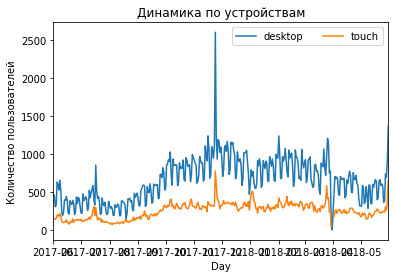

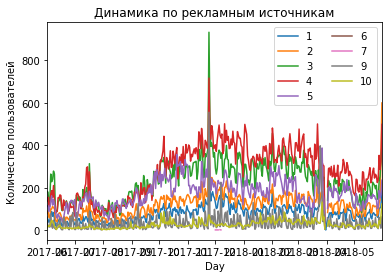

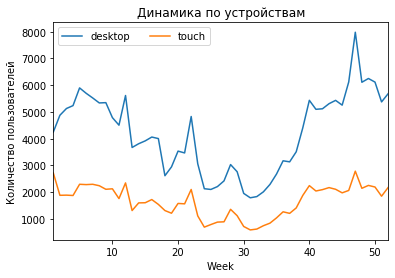

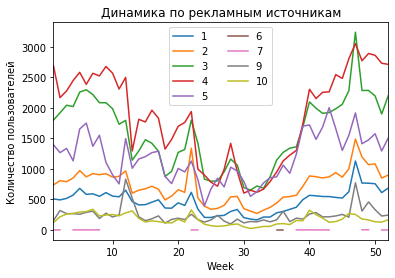

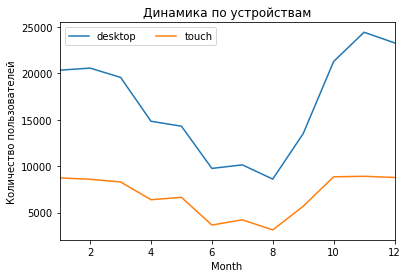

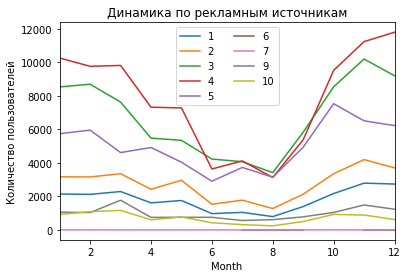

In [23]:
attendance_metrics_list = ['Day','Week','Month']
for metrics_parametr in attendance_metrics_list:
    print()
    print('Параметр - ' + metrics_parametr)
    attendance_metrics(metrics_parametr, 'nunique') 

В среднем сервисом пользуются:
- в день 908 пользователей (DAU);
- в неделю 5825 пользователей (WAU);
- в месяц 23228 пользователей (MAU). 

В разрезе категорий устройств пользователя и рекламных источников
- DAU: стационарный компьютер - 659, сенсорное устройство - 253, по рекламным источникам от 1 (источники 6 и 7) до 275 (источник 4);
- WAU: стационарный компьютер - 4208, сенсорное устройство - 1666, по рекламным источникам от 1 (источники 6 и 7) до 1864 (источник 4);
- MAU: стационарный компьютер - 16725, сенсорное устройство - 6826, по рекламным источникам от 1 (источники 6) до 7766 (источник 4).

Большинство пользователей для обрашения на сайт использовали стационарный компьютер, основным рекламным источником был 4. Активности пользователей свойственна сезонность. Существенных изменений в количестве пользователей в разрезе устройств и рекламных источников не произошло. 



Рассчитаем количество сессий в день.


Параметр - Day
Среднее количество пользователей: 987
device
desktop    721.0
touch      267.0
dtype: float64
source_id
1      94.0
2     131.0
3     236.0
4     280.0
5     184.0
6       1.0
7       1.0
9      37.0
10     28.0
dtype: float64

Параметр - Week
Среднее количество пользователей: 6912
device
desktop    5049.0
touch      1862.0
dtype: float64
source_id
1      656.0
2      916.0
3     1646.0
4     1958.0
5     1287.0
6        1.0
7        1.0
9      255.0
10     193.0
dtype: float64

Параметр - Month
Среднее количество пользователей: 29950
device
desktop    21881.0
touch       8069.0
dtype: float64
source_id
1     2843.0
2     3969.0
3     7134.0
4     8483.0
5     5575.0
6        1.0
7        3.0
9     1106.0
10     835.0
dtype: float64


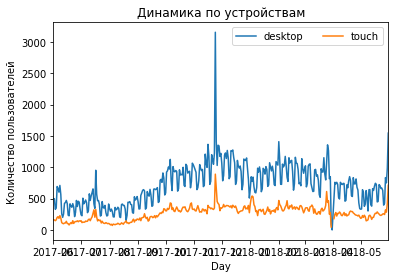

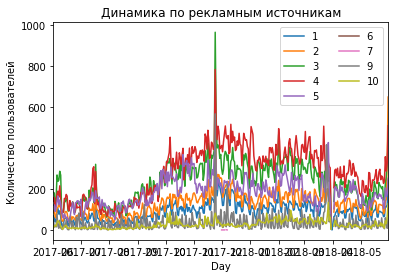

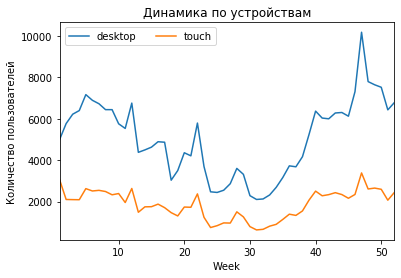

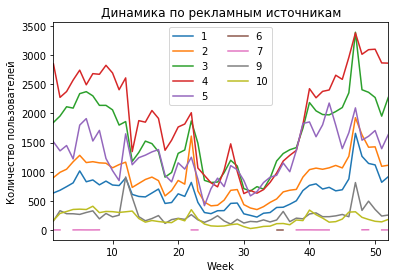

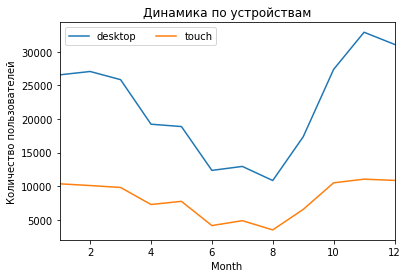

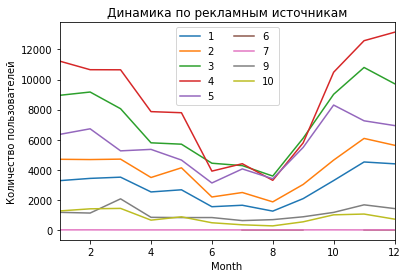

In [24]:
attendance_metrics_list = ['Day','Week','Month']
for metrics_parametr in attendance_metrics_list:
    print()
    print('Параметр - ' + metrics_parametr)
    attendance_metrics(metrics_parametr, 'count') 

В среднем пользователи совершают в день 987 сессий, в неделю 6912 сессий, в месяц 29950 сессий. Ежедневные сессии: стационарный компьютер - 721, сенсорное устройство - 267, по рекламным источникам от 1 (источники 6 и 7) до 280 (источник 4). Еженежельные сессии: стационарный компьютер - 5049, сенсорное устройство - 1862, по рекламным источникам от 1 (источники 6 и 7) до 1958 (источник 4). Ежемесячные: стационарный компьютер - 21881, сенсорное устройство - 8069, по рекламным источникам от 1 (источники 6) до 8483 (источник 4). Большинство пользователей для обрашения на сайт использовали стационарный компьютер, основным рекламным источником был 4. Активности пользователей свойственна сезонность. Существенных изменений в количестве сессий в разрезе устройств и рекламных источников также не произошло.

In [25]:
# Расчитаем длительность сессии
clients_visits['session_duration_sec'] = (clients_visits['end_ts'] - clients_visits['start_ts']).dt.seconds

In [26]:
clients_visits['session_duration_sec'].mean()

643.506488592098

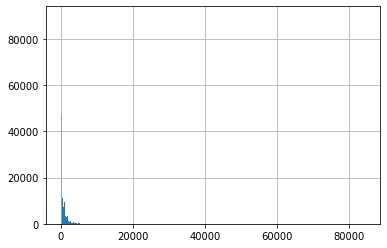

In [27]:
clients_visits['session_duration_sec'].hist(bins=1000)

Учитывая, что распределение не соответствует нормальному, рассчитаем моду (значение в выборке, которое встречается чаще всего):

In [28]:
#Продолжительность по устройствам
clients_visits.pivot_table(index='device', values='session_duration_sec', aggfunc=st.mode)

,session_duration_sec
device,
desktop,"([60], [35411])"
touch,"([60], [17618])"


,session_duration_sec
source_id,
1,"([60], [3088])"
2,"([60], [5902])"
3,"([60], [13521])"
4,"([60], [15822])"
5,"([60], [11044])"
6,"([0], [1])"
7,"([120], [9])"
9,"([60], [2095])"
10,"([60], [1551])"


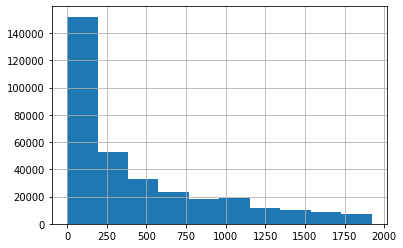

In [29]:
#Продолжительность по источникам
clients_visits_clean = clients_visits.query('session_duration_sec<=1920')
clients_visits_clean['session_duration_sec'].hist()
clients_visits_clean.pivot_table(index='source_id', values='session_duration_sec', aggfunc=st.mode)


In [30]:
session = clients_visits.pivot_table(index='source_id',values='Uid', aggfunc='count')
session.columns = ['count_sessions']
null_session_duration = clients_visits.query('session_duration_sec==0').pivot_table(index='source_id',values='Uid', aggfunc='count')
null_session_duration.columns = ['null_sessions']
session = session.join(null_session_duration, on='source_id')
session['share_null_session, %'] = session['null_sessions'] / session['count_sessions'] * 100
session

,count_sessions,null_sessions,"share_null_session, %"
source_id,,,
1,34121,1975,5.788224
2,47626,4158,8.730525
3,85610,9025,10.541993
4,101794,10898,10.705936
5,66905,7385,11.038039
6,6,1,16.666667
7,36,1,2.777778
9,13277,1297,9.768773
10,10025,1054,10.513716


В среднем сессия длится 643 секунды - около 11 минут. Вместе с тем, распределение продолжительности сессий не соответствует нормальному. Учитывая изложенное, наиболее предпочтительной характеристикой продолжительности сессии являеся Мода - наиболее часто встречающаяся продолжительность - 60 секунд вне зависимости от устройства или рекламного источника, за исключением рекламного источника 7, у которого - 120 секунд.
В среднем 10,0% сессий нулевые. При этом количество нулевых сессий находится в промежутке от 5,8% (источник 1) до 11,0% (источник 5).

Для ответа на вопрос "Как часто люди возвращаются?" рассчитаем и построим Тепловую карту коэффициента удержания (Retention Rate).

In [31]:
# Добавим столбец с сроком в месяцах, прошедших с момента первого визита
clients_visits['cohort_lifetime'] = clients_visits['visit_month'] - clients_visits['first_visit_month']
clients_visits['cohort_lifetime'] = clients_visits['cohort_lifetime'] / np.timedelta64(1,'M')
clients_visits['cohort_lifetime'] = clients_visits['cohort_lifetime'].round().astype(int)

In [32]:
cohorts = clients_visits.groupby(['first_visit_month','cohort_lifetime']).agg({'Uid':'nunique'}).reset_index()

In [33]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','Uid']]
initial_users_count = initial_users_count.rename(columns={'Uid':'cohort_users'})

In [34]:
cohorts = cohorts.merge(initial_users_count,on='first_visit_month')

In [35]:
cohorts['retention'] = cohorts['Uid']/cohorts['cohort_users']
retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum')

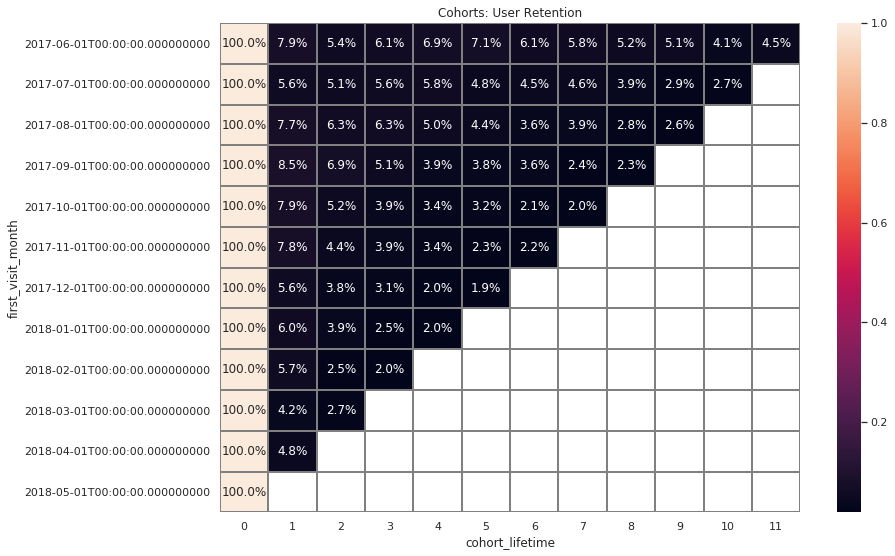

In [36]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray');

Согласно полученным значениям, менее 10% пользователей из когорты относительно их изначального числа вернулось в последующие периоды. Вместе с тем, обращаем внимание, что на значение Коэффициента удержания оказывает большее влияние не количество месяцев, прошедших с первого визита пользователя, а сам месяц расчета, что связано с сезонной активностью пользователей.

In [37]:
# Найдем дату первого заказа
first_order_date_by_clients = clients_orders.groupby('Uid')['Buy Ts'].min()
first_order_date_by_clients.name = 'first_order_date'

In [38]:
# Добавим дату первого заказа в таблицу заказов
clients_orders = clients_orders.join(first_order_date_by_clients,on='Uid')
clients_orders['first_order_month'] = clients_orders['first_order_date'].astype('datetime64[M]')
clients_orders['order_month'] = clients_orders['Buy Ts'].astype('datetime64[M]')

In [39]:
clients_orders['deal'] = clients_orders['first_order_date'] - clients_orders['first_visit_date']


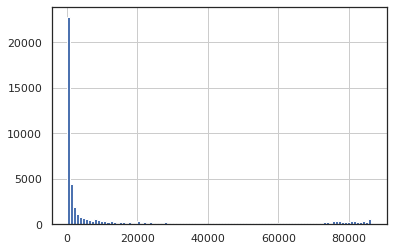

In [40]:
#Посмотрим распределение времени до сделки
clients_orders['deal'].dt.seconds.reset_index()['deal'].hist(bins=100)

In [41]:
st.mode(clients_orders['deal'].dt.seconds)

ModeResult(mode=array([0]), count=array([3929]))

In [42]:
null_time = '0 days 00:00:00'
st.mode(clients_orders.query('deal!=@null_time')['deal'].dt.seconds)

ModeResult(mode=array([60]), count=array([3286]))

Наиболее часто встречающаяся продолжительность времени, которое проходит у покупателей между первым визитом и заказом, 0 секунд. Следующим по частоте является продолжительность в 1 минуту.

Рассчитаем сколько раз клиенты покупают в месяц

In [43]:
col_orders = clients_orders.groupby(['order_month','Uid']).agg({'Uid':['count','nunique']})
col_orders.columns = ['col_orders','col_clients']
col_orders['mean_col_orders'] = col_orders['col_orders'] / col_orders['col_clients']
print('Среднемесячное количество заказов по когортам от {:0.2f} до {:0.2f}'.format(col_orders['mean_col_orders'].min(), col_orders['mean_col_orders'].max()))


Среднемесячное количество заказов по когортам от 1.00 до 67.00


Клиенты делают в месяц от 1.00 до 67 заказов

In [44]:
# Сгруппируем информацию о заказах по месяцу первого визита покупателя и месяцем заказа
orders_grouped_by_cohorts = clients_orders.groupby(['first_visit_month','order_month']).agg({'Uid':'nunique','Revenue':'sum'})


In [45]:
# Найдём средний чек покупателя revenue_per_user
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['Revenue'] / orders_grouped_by_cohorts['Uid']

In [46]:
orders_grouped_by_cohorts.pivot_table(index='first_visit_month',columns='order_month',values='revenue_per_user',aggfunc='mean')


order_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
first_visit_month,,,,,,,,,,,,,
2017-06-01,4.724414,11.534978,11.354186,20.649415,15.333035,13.913695,18.465344,14.650387,13.476221,22.318205,19.333421,11.543772,NaN
2017-07-01,NaN,5.633137,7.846519,7.442282,6.382857,5.535882,6.000602,4.819672,6.017969,6.300174,8.208750,6.228800,NaN
2017-08-01,NaN,NaN,5.161267,6.393077,7.256159,8.087265,7.864466,7.011842,6.403289,14.491047,15.672453,6.477931,NaN
2017-09-01,NaN,NaN,NaN,5.475055,10.138301,8.757801,58.645674,11.607928,13.643214,6.906000,7.121449,4.500753,NaN
2017-10-01,NaN,NaN,NaN,NaN,4.882297,8.003845,4.544589,5.370812,5.270051,5.775085,4.990603,5.332520,NaN
2017-11-01,NaN,NaN,NaN,NaN,NaN,4.924573,4.797806,5.105894,7.483770,5.516119,6.492018,5.415504,NaN
2017-12-01,NaN,NaN,NaN,NaN,NaN,NaN,4.828702,5.269788,22.213228,27.400107,16.753678,14.372016,NaN
2018-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.007946,6.099063,6.655771,3.871899,5.860778,NaN
2018-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.036687,7.062135,6.698889,8.500094,NaN


In [47]:
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_visit_month']
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')

In [48]:
# Построим сводную таблицу изменения среднего чека, где в столбцах будет lifetime, а строках — когорты:
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='revenue_per_user',aggfunc='mean')

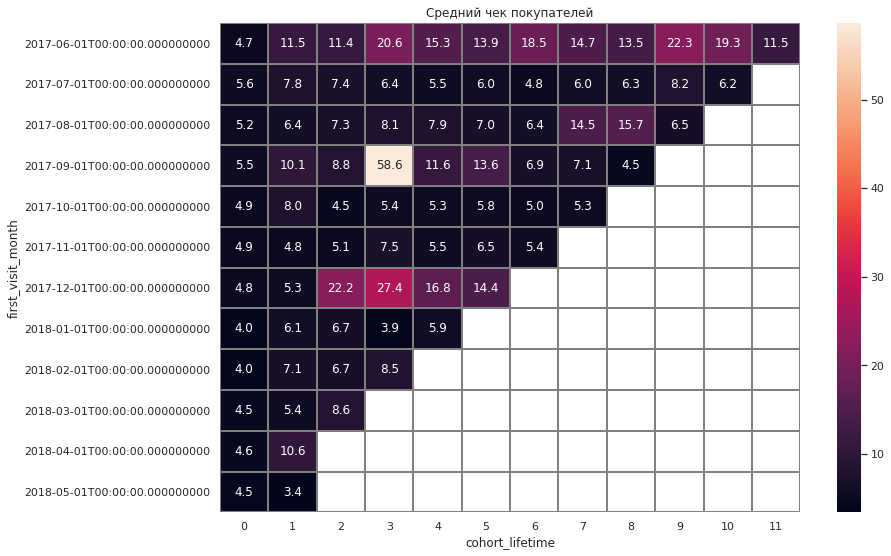

In [49]:
plt.figure(figsize=(13, 9))
plt.title('Средний чек покупателей')
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='grey')

In [50]:
revenue_per_user_pivot.mean(axis=0)

cohort_lifetime
0      4.768816
1      7.209165
2      8.863735
3     16.265766
4      9.217742
5      9.601210
6      7.833402
7      9.522674
8      9.987400
9     12.334962
10    12.781111
11    11.543772
dtype: float64

Со временем средний чек растет, составляя на первом месяце жизни 4,77 ед. повышаясь к четвертому месяцу до 16,26 ед. и составляя на двенадцатом месяце 11,54 ед.

Рассчитаем LTV (от англ. lifetime value) — «пожизненную» ценность клиента. 

In [51]:
# Примем маржинальность за 100% и добавим столбец с прибылью
margin_rate = 1.0
clients_orders['gp'] = clients_orders['Revenue'] * margin_rate

In [52]:
marketing_costs_in_month = marketing_costs.groupby(['costs_month','source_id'])['costs'].sum().reset_index()
marketing_costs_in_month.columns = ['costs_month','source_id','costs_on_source']
clients_orders = clients_orders.merge(marketing_costs_in_month, left_on=['source_id','first_visit_month'], right_on=['source_id', 'costs_month'], how='left')

clients_orders['cost_per_unit_by_source'] = clients_orders['costs_on_source'] / clients_orders['n_bayers_by_source']

In [53]:
total_table = clients_orders.groupby(['first_visit_month','cohort_lifetime','source_id','device']).agg({'n_bayers_by_device':'mean','n_bayers_by_source':'mean','gp':'sum','cost_per_unit_by_source':'mean','costs_on_source':'mean'})
total_table['costs_by_device'] = total_table['n_bayers_by_device'] * total_table['cost_per_unit_by_source']
total_table['ltv_device'] = total_table['gp'] / total_table['n_bayers_by_device']

In [54]:
total_table

n_bayers_by_device  \
first_visit_month cohort_lifetime source_id device                        
2017-06-01        0               1         desktop                 203   
                                            touch                    37   
                                  2         desktop                 300   
                                            touch                    74   
                                  3         desktop                 751   
...                                                                 ...   
2018-05-01        0               9         desktop                  26   
                                            touch                     4   
                                  10        desktop                  74   
                                            touch                    27   
                  1               4         desktop                 477   

                                                     n_bayers_by_source  \
first_visit_month cohort_lifetime source_id device                        
2017-06-01        0               1         desktop                 240   
                                            touch                   240   
                                  2         desktop                 374   
                                            touch                   374   
                                  3         desktop                 886   
...                                                                 ...   
2018-05-01        0               9         desktop                  30   
                                            touch                    30   
                                  10        desktop                 101   
                                            touch                   101   
                  1               4         desktop                 611   

                                                          gp  \
first_visit_month cohort_lifetime source_id device             
2017-06-01        0               1         desktop  1249.17   
                                            touch     129.53   
                                  2         desktop   918.33   
                                            touch     125.35   
                                  3         desktop  2542.73   
...                                                      ...   
2018-05-01        0               9         desktop    73.56   
                                            touch      10.26   
                                  10        desktop   310.88   
                                            touch      53.46   
                  1               4         desktop     3.42   

                                                     cost_per_unit_by_source  \
first_visit_month cohort_lifetime source_id device                             
2017-06-01        0               1         desktop                 4.690042   
                                            touch                   4.690042   
                                  2         desktop                 6.490321   
                                            touch                   6.490321   
                                  3         desktop                 8.726467   
...                                                                      ...   
2018-05-01        0               9         desktop                12.072333   
                                            touch                  12.072333   
                                  10        desktop                 4.058020   
                                            touch                   4.058020   
                  1               4         desktop                 6.897234   

                                                     costs_on_source  \
first_visit_month cohort_lifetime source_id device                     
2017-06-01        0               1         desktop          1125.61   
           

In [55]:
# Расситаем сколько было всего расходов и разбивку по месяцам
all_costs = total_table.query('cohort_lifetime==0').pivot_table(index='first_visit_month', values='costs_by_device', aggfunc='sum', margins=True)
all_costs.columns = ['all_costs']
all_costs

,all_costs
first_visit_month,
2017-06-01 00:00:00,18015.00
2017-07-01 00:00:00,18240.59
2017-08-01 00:00:00,14790.54
2017-09-01 00:00:00,24368.91
2017-10-01 00:00:00,36322.88
2017-11-01 00:00:00,37907.88
2017-12-01 00:00:00,38315.35
2018-01-01 00:00:00,33518.52
2018-02-01 00:00:00,32723.03


За период с июня 2017 по май 2018 было потрачено 329 тыс. ед., при этом расходы варировались от 18,0 тыс. в июне 2017 до 38,3 тыс. в декабре 2017 года.

In [56]:
# Рассчитаем затраты по рекламным источникам 
costs_by_sources = total_table.query('cohort_lifetime==0').pivot_table(index='source_id', values='costs_by_device', aggfunc='sum', margins=True)
costs_by_sources.columns = ['costs_by_sources']
costs_by_sources

,costs_by_sources
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
7,0.00
9,5517.49
10,5822.49
All,329131.62


Расходы по ркламным источникам варьировались от 5,5 тыс. ед. на рекламный источник 9 до 141,3 тыс. ед. на рекламный источник 3. 

In [57]:
# Рассчитаем затраты по категориям устройств 
costs_by_device = total_table.query('cohort_lifetime==0').pivot_table(index=['first_visit_month','device'], values='costs_by_device', aggfunc='sum', margins=True)
costs_by_device.columns = ['costs_by_device']
costs_by_device

costs_by_device
first_visit_month   device                  
2017-06-01 00:00:00 desktop     14808.995828
                    touch        3206.004172
2017-07-01 00:00:00 desktop     14355.637056
                    touch        3884.952944
2017-08-01 00:00:00 desktop     12010.131621
                    touch        2780.408379
2017-09-01 00:00:00 desktop     19280.175096
                    touch        5088.734904
2017-10-01 00:00:00 desktop     29692.497959
                    touch        6630.382041
2017-11-01 00:00:00 desktop     31147.776405
                    touch        6760.103595
2017-12-01 00:00:00 desktop     30868.660704
                    touch        7446.689296
2018-01-01 00:00:00 desktop     26670.196156
                    touch        6848.323844
2018-02-01 00:00:00 desktop     25555.596789
                    touch        7167.433211
2018-03-01 00:00:00 desktop     24366.532414
                    touch        6048.737586
2018-04-01 00:00:00 desktop     18288.127084
                    touch        4001.252916
2018-05-01 00:00:00 desktop     17854.954403
                    touch        4369.315597
All                            329131.620000

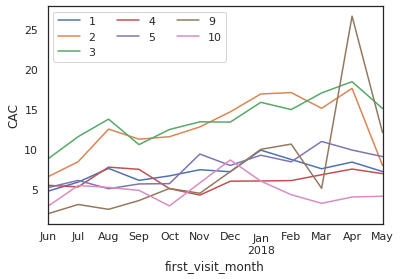

In [58]:
total_table.pivot_table(index='first_visit_month', columns='source_id', values='cost_per_unit_by_source').plot().legend(ncol=3)
plt.ylabel('CAC');

Согласно графику:
- в июне 2017 года самая низкая стоимость привлечения была из рекламмных источников 9 и 10 (2 и 3 ед. соответственно), самая дорогая - из 3 и 2 (9 и 7 ед. соответственно). Из остальных источников стоимость привлечения покупателя составляла около 5 ед.
- В мае 2018 года самая низкая стоимость привлечения была у рекламного источника 10 (4 ед.), самая высокая у 3 и 9 (14 ед. и 11 ед. соответственно, при чем стоимость привлечение из источника 9 за период увеличилась на 9 ед.). Из остальных источников стоимость привлечения тоже увеличилась и составила от 6 до 8 ед.

In [59]:
clients_orders.head(1)

,Buy Ts,Revenue,Uid,first_visit_date,first_visit_month,order_month,start_ts,device,source_id,cohort_lifetime,...,n_bayers_by_device,n_visitors_by_source,n_bayers_by_source,first_order_date,first_order_month,deal,gp,costs_month,costs_on_source,cost_per_unit_by_source
0,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01 00:09:00,2017-06-01,2017-06-01,2017-06-01 00:09:00,desktop,1,0,...,203,1513,240,2017-06-01 00:10:00,2017-06-01,00:01:00,17.0,2017-06-01,1125.61,4.690042


In [60]:
for_metrics = clients_orders[['gp','Uid','first_visit_month','cohort_lifetime','device','source_id']].copy()

In [61]:
cogorts_table = for_metrics.pivot_table(index=['first_visit_month','cohort_lifetime'], values=['gp'], aggfunc={'gp':'sum'})
n_units = for_metrics.pivot_table(index='first_visit_month', values='Uid', aggfunc={'Uid':'nunique'})
cogorts_table = cogorts_table.join(n_units).reset_index()
cogorts_table['LTV_cogort'] = cogorts_table['gp'] / cogorts_table['Uid']
costs_by_month = marketing_costs.pivot_table(index='costs_month', values='costs', aggfunc='sum').reset_index()
cogorts_table = cogorts_table.merge(costs_by_month, left_on=['first_visit_month'], right_on=['costs_month'], how='left')
cogorts_table['CAC'] = cogorts_table['costs'] / cogorts_table['Uid']

cogorts_table

,first_visit_month,cohort_lifetime,gp,Uid,LTV_cogort,costs_month,costs,CAC
0,2017-06-01,0,9557.49,2923,3.269754,2017-06-01,18015.00,6.163189
1,2017-06-01,1,2664.58,2923,0.911591,2017-06-01,18015.00,6.163189
2,2017-06-01,2,1464.69,2923,0.501091,2017-06-01,18015.00,6.163189
3,2017-06-01,3,3882.09,2923,1.328118,2017-06-01,18015.00,6.163189
4,2017-06-01,4,3940.59,2923,1.348132,2017-06-01,18015.00,6.163189
...,...,...,...,...,...,...,...,...
74,2018-03-01,2,774.77,2838,0.272999,2018-03-01,30415.27,10.717149
75,2018-04-01,0,8043.82,1890,4.255989,2018-04-01,22289.38,11.793323
76,2018-04-01,1,1838.73,1890,0.972873,2018-04-01,22289.38,11.793323
77,2018-05-01,0,10368.11,2316,4.476731,2018-05-01,22224.27,9.595972


In [62]:
cogorts_table_ltv = cogorts_table.pivot_table(index='first_visit_month', columns='cohort_lifetime', values='LTV_cogort', aggfunc='mean')
cogorts_table_ltv

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,3.269754,0.911591,0.501091,1.328118,1.348132,0.966295,1.193962,0.776876,0.792990,1.191119,0.754023,0.659531
2017-07-01,4.017449,0.430952,0.451139,0.399902,0.344585,0.324687,0.239219,0.313385,0.294760,0.240452,0.190057,NaN
2017-08-01,3.622783,0.579500,0.581842,0.549802,0.470680,0.309646,0.282772,0.724131,0.482650,0.218315,NaN,NaN
2017-09-01,4.040942,1.210098,0.690199,3.413646,0.421347,0.624608,0.316167,0.160687,0.136877,NaN,NaN,NaN
2017-10-01,3.925250,0.814414,0.283673,0.226176,0.223059,0.218510,0.123752,0.140209,NaN,NaN,NaN,NaN
2017-11-01,3.878881,0.625899,0.315075,0.321335,0.260145,0.166032,0.163914,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.137703,0.426861,1.030511,1.257688,0.357774,0.437440,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3.397567,0.625745,0.373440,0.098070,0.169115,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,3.613506,0.622869,0.208158,0.282803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
cogorts_table_ltv.cumsum(axis=1).round(2)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,3.27,4.18,4.68,6.01,7.36,8.32,9.52,10.30,11.09,12.28,13.03,13.69
2017-07-01,4.02,4.45,4.90,5.30,5.64,5.97,6.21,6.52,6.82,7.06,7.25,NaN
2017-08-01,3.62,4.20,4.78,5.33,5.80,6.11,6.40,7.12,7.60,7.82,NaN,NaN
2017-09-01,4.04,5.25,5.94,9.35,9.78,10.40,10.72,10.88,11.01,NaN,NaN,NaN
2017-10-01,3.93,4.74,5.02,5.25,5.47,5.69,5.81,5.96,NaN,NaN,NaN,NaN
2017-11-01,3.88,4.50,4.82,5.14,5.40,5.57,5.73,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.14,4.56,5.60,6.85,7.21,7.65,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3.40,4.02,4.40,4.49,4.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,3.61,4.24,4.44,4.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
cogorts_table_ltv.cumsum(axis=1).mean(axis=0)

cohort_lifetime
0      3.905741
1      4.536492
2      4.943896
3      5.829381
4      6.416492
5      7.102173
6      7.397837
7      8.154206
8      9.130816
9      9.052860
10    10.140269
11    13.693483
dtype: float64

LTV клиентов за период 6 месяцев составила 7,1 ед. Показатели в разрезе рекламных источников и устройств, будут проанализированы при описании результатов анализа показаля ROMI (LTV/CAC).

In [65]:
cogorts_table['romi'] = cogorts_table['LTV_cogort'] / cogorts_table['CAC']
output = cogorts_table.pivot_table(
        index='first_visit_month', 
        columns='cohort_lifetime', 
        values='romi', 
        aggfunc='mean')

output.cumsum(axis=1).round(2)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_visit_month,,,,,,,,,,,,
2017-06-01,0.53,0.68,0.76,0.98,1.19,1.35,1.54,1.67,1.80,1.99,2.11,2.22
2017-07-01,0.54,0.60,0.66,0.71,0.76,0.80,0.84,0.88,0.92,0.95,0.98,NaN
2017-08-01,0.42,0.49,0.56,0.62,0.68,0.71,0.74,0.83,0.88,0.91,NaN,NaN
2017-09-01,0.51,0.66,0.75,1.17,1.23,1.31,1.34,1.37,1.38,NaN,NaN,NaN
2017-10-01,0.51,0.61,0.65,0.68,0.70,0.73,0.75,0.77,NaN,NaN,NaN,NaN
2017-11-01,0.44,0.51,0.54,0.58,0.61,0.63,0.64,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.44,0.49,0.59,0.73,0.77,0.81,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.32,0.37,0.41,0.42,0.43,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.35,0.41,0.43,0.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Отберем когорты, которые прожили не менее 6 месяцев.

In [66]:
output.loc[:'2017-12-01'][range(0,6)].cumsum(axis=1).round(2)

cohort_lifetime,0,1,2,3,4,5
first_visit_month,,,,,,
2017-06-01,0.53,0.68,0.76,0.98,1.19,1.35
2017-07-01,0.54,0.60,0.66,0.71,0.76,0.80
2017-08-01,0.42,0.49,0.56,0.62,0.68,0.71
2017-09-01,0.51,0.66,0.75,1.17,1.23,1.31
2017-10-01,0.51,0.61,0.65,0.68,0.70,0.73
2017-11-01,0.44,0.51,0.54,0.58,0.61,0.63
2017-12-01,0.44,0.49,0.59,0.73,0.77,0.81


Среди когорт за период с июня по декабрь 2017 года в течение 6 месяцев окупили расходы на маркетинг июньская и сентябрьская. 

### Рассчитаем ROMI по рекламным источникам

In [67]:
sources_table = for_metrics.pivot_table(index=['source_id','cohort_lifetime'], values=['gp'], aggfunc={'gp':'sum'})
n_units = for_metrics.pivot_table(index=['source_id'], values='Uid', aggfunc={'Uid':'nunique'})
sources_table = sources_table.join(n_units).reset_index()
sources_table['LTV_source'] = sources_table['gp'] / sources_table['Uid']
costs_by_month = marketing_costs.pivot_table(index=['source_id'], values='costs', aggfunc='sum').reset_index()

sources_table = sources_table.merge(costs_by_month, left_on=['source_id'], right_on=['source_id'], how='left')
sources_table['CAC'] = sources_table['costs'] / sources_table['Uid']

sources_table

,source_id,cohort_lifetime,gp,Uid,LTV_source,costs,CAC
0,1,0,14526.97,2899,5.011028,20833.27,7.186364
1,1,1,2613.99,2899,0.901687,20833.27,7.186364
2,1,2,1795.52,2899,0.619358,20833.27,7.186364
3,1,3,2734.87,2899,0.943384,20833.27,7.186364
4,1,4,1691.99,2899,0.583646,20833.27,7.186364
...,...,...,...,...,...,...,...
80,10,7,25.97,1329,0.019541,5822.49,4.381106
81,10,8,4.28,1329,0.003220,5822.49,4.381106
82,10,9,17.69,1329,0.013311,5822.49,4.381106
83,10,10,7.82,1329,0.005884,5822.49,4.381106


In [68]:
sources_table_ltv = sources_table.pivot_table(index=['source_id'], columns='cohort_lifetime', values='LTV_source', aggfunc='mean')
sources_table_ltv

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,5.011028,0.901687,0.619358,0.943384,0.583646,0.384350,0.322318,0.761683,0.432125,0.299910,0.284108,0.180980
2,5.107074,1.728183,1.724518,1.853146,0.910887,0.705719,0.348160,0.222966,0.214421,0.271831,0.186962,0.109934
3,3.600758,0.564708,0.236312,0.213627,0.189864,0.131660,0.102390,0.055370,0.049017,0.028180,0.018731,0.014311
4,3.637585,0.432876,0.206434,0.202110,0.171282,0.208751,0.202077,0.069360,0.092296,0.132675,0.077192,0.074048
5,4.152723,0.493790,0.290739,1.568736,0.253483,0.310812,0.166259,0.133502,0.078375,0.112992,0.019486,0.011661
7,1.220000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.182500,0.579982,0.525772,0.467472,0.419844,0.207849,0.254660,0.183355,0.253686,0.150662,0.053520,0.014265
10,2.674545,0.227878,0.095779,0.057728,0.129526,0.060512,0.053860,0.019541,0.003220,0.013311,0.005884,0.006847


In [69]:
sources_table_ltv.cumsum(axis=1).round(2)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,5.01,5.91,6.53,7.48,8.06,8.44,8.77,9.53,9.96,10.26,10.54,10.72
2,5.11,6.84,8.56,10.41,11.32,12.03,12.38,12.60,12.82,13.09,13.27,13.38
3,3.60,4.17,4.40,4.62,4.81,4.94,5.04,5.09,5.14,5.17,5.19,5.20
4,3.64,4.07,4.28,4.48,4.65,4.86,5.06,5.13,5.22,5.36,5.43,5.51
5,4.15,4.65,4.94,6.51,6.76,7.07,7.24,7.37,7.45,7.56,7.58,7.59
7,1.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.18,2.76,3.29,3.76,4.18,4.38,4.64,4.82,5.08,5.23,5.28,5.29
10,2.67,2.90,3.00,3.06,3.19,3.25,3.30,3.32,3.32,3.34,3.34,3.35


In [70]:
sources_table['romi'] = sources_table['LTV_source'] / sources_table['CAC']
output = sources_table.pivot_table(
        index='source_id', 
        columns='cohort_lifetime', 
        values='romi', 
        aggfunc='mean')

output.cumsum(axis=1).round(2)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,0.70,0.82,0.91,1.04,1.12,1.17,1.22,1.33,1.39,1.43,1.47,1.49
2,0.42,0.56,0.70,0.85,0.93,0.99,1.01,1.03,1.05,1.07,1.09,1.10
3,0.27,0.31,0.33,0.34,0.36,0.37,0.37,0.38,0.38,0.38,0.38,0.39
4,0.61,0.69,0.72,0.76,0.78,0.82,0.85,0.86,0.88,0.90,0.92,0.93
5,0.56,0.62,0.66,0.87,0.91,0.95,0.97,0.99,1.00,1.01,1.02,1.02
9,0.43,0.54,0.65,0.74,0.82,0.86,0.91,0.95,1.00,1.03,1.04,1.04
10,0.61,0.66,0.68,0.70,0.73,0.74,0.75,0.76,0.76,0.76,0.76,0.76


За 12 месяцев расходы на маркетинг:
- полностью окупились по рекламным источникам 1,2,5 и 9;
- на рекламные источники 3,4 и 10 окупились на 39%, 93% и 76% соответственно.

### Расчет ROMI по категориям устройств

In [71]:
marketing_costs

,source_id,dt,costs,costs_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01
...,...,...,...,...
2537,10,2018-05-27,9.92,2018-05-01
2538,10,2018-05-28,21.26,2018-05-01
2539,10,2018-05-29,11.32,2018-05-01
2540,10,2018-05-30,33.15,2018-05-01


In [72]:
devices_table = for_metrics.pivot_table(index=['device','cohort_lifetime'], values=['gp'], aggfunc={'gp':'sum'})
n_units = for_metrics.pivot_table(index=['device'], values='Uid', aggfunc={'Uid':'nunique'})
devices_table = devices_table.join(n_units).reset_index()
devices_table['LTV_device'] = devices_table['gp'] / devices_table['Uid']
col_units = n_units['Uid'].sum()
all_marketing_costs = marketing_costs['costs'].sum()
CAC = all_marketing_costs / col_units
devices_table['CAC'] = CAC
devices_table

,device,cohort_lifetime,gp,Uid,LTV_device,CAC
0,desktop,0,117165.49,29211,4.011006,9.011626
1,desktop,1,18442.39,29211,0.631351,9.011626
2,desktop,2,13011.79,29211,0.445441,9.011626
3,desktop,3,23398.22,29211,0.801007,9.011626
4,desktop,4,9767.11,29211,0.334364,9.011626
5,desktop,5,8385.28,29211,0.287059,9.011626
6,desktop,6,5949.24,29211,0.203664,9.011626
7,desktop,7,4255.13,29211,0.145669,9.011626
8,desktop,8,3330.05,29211,0.114000,9.011626
9,desktop,9,3540.78,29211,0.121214,9.011626


In [73]:
devices_table_ltv = devices_table.pivot_table(index=['device'], columns='cohort_lifetime', values='LTV_device', aggfunc='mean')
devices_table_ltv

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
device,,,,,,,,,,,,
desktop,4.011006,0.631351,0.445441,0.801007,0.334364,0.287059,0.203664,0.145669,0.114000,0.121214,0.081688,0.058132
touch,3.438590,0.678066,0.293308,0.220222,0.171805,0.163044,0.117575,0.161309,0.131508,0.124126,0.038974,0.031415


In [74]:
devices_table_ltv.cumsum(axis=1).round(2)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
device,,,,,,,,,,,,
desktop,4.01,4.64,5.09,5.89,6.22,6.51,6.71,6.86,6.97,7.09,7.18,7.23
touch,3.44,4.12,4.41,4.63,4.80,4.97,5.08,5.24,5.38,5.50,5.54,5.57


In [75]:
devices_table['romi'] = devices_table['LTV_device'] / devices_table['CAC']
output = devices_table.pivot_table(
        index='device', 
        columns='cohort_lifetime', 
        values='romi', 
        aggfunc='mean')

output.cumsum(axis=1).round(2)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
device,,,,,,,,,,,,
desktop,0.45,0.52,0.56,0.65,0.69,0.72,0.75,0.76,0.77,0.79,0.80,0.80
touch,0.38,0.46,0.49,0.51,0.53,0.55,0.56,0.58,0.60,0.61,0.61,0.62


За 12 месяцев расходы на маркетинг по стационарным и сенсорным устройствам окупились на 80% и 62% соответственно.

## Общий вывод
В среднем сервисом пользуются в день 908 пользователей, в неделю 5825 пользователей, в месяц 23228 пользователей.
- DAU: стационарный компьютер - 659, сенсорное устройство - 253, по рекламным источникам от 1 (источники 6 и 7) до 275 (источник 4). 
- WAU: стационарный компьютер - 4208, сенсорное устройство - 1666, по рекламным источникам от 1 (источники 6 и 7) до 1864 (источник 4). 
- MAU: стационарный компьютер - 16725, сенсорное устройство - 6826, по рекламным источникам от 1 (источники 6) до 7766 (источник 4). 

В среднем пользователи совершают в день 987 сессий, в неделю 6912 сессий, в месяц 29950 сессий. 

- Ежедневные сессии: стационарный компьютер - 721, сенсорное устройство - 267, по рекламным источникам от 1 (источники 6 и 7) до 280 (источник 4). 
- Еженедельные сессии: стационарный компьютер - 5049, сенсорное устройство - 1862, по рекламным источникам от 1 (источники 6 и 7) до 1958 (источник 4). 
- Ежемесячные: стационарный компьютер - 21881, сенсорное устройство - 8069, по рекламным источникам от 1 (источники 6) до 8483 (источник 4). 

Большинство пользователей для обрашения на сайт использовали стационарный компьютер, основным рекламным источником был 4. Активности пользователей свойственна сезонность. Существенных изменений в количестве сессий в разрезе устройств и рекламных источников также не произошло.

В среднем сессия длится 643 секунды - около 11 минут. Вместе с тем, распределение продолжительности сессий не соответствует нормальному. Учитывая изложенное, наиболее предпочтительной характеристикой продолжительности сессии являеся Мода - наиболее часто встречающаяся продолжительность - 60 секунд вне зависимости от устройства или рекламного источника, за исключением рекламного источника 7, у которого - 120 секунд. В среднем 10,0% сессий нулевые. При этом количество нулевых сессий находится в промежутке от 5,8% (источник 1) до 11,0% (источник 5).

Согласно полученным значениям, менее 10% пользователей из когорты относительно их изначального числа вернулось в последующие периоды. Вместе с тем, обращаем внимание, что на значение Коэффициента удержания оказывает большее влияние не количество месяцев, прошедших с первого визита пользователя, а сам месяц расчета, что связано с сезонной активностью пользователей.

Наиболее частым значением времени, которое проходит у покупателей между первым визитом и заказом, является 0 минуты, следующим по частоте - 1 минута. Клиенты делают в месяц от 1 до 67 заказов.

Со временем средний чек растет, составляя на первом месяце жизни 4,77 ед. повышаясь к четвертому месяцу до 16,26 ед. и составляя на двенадцатом месяце 11,54 ед.

Средняя LTV клиентов за период 6 месяцев составила 7,1 ед.

За период с июня 2017 по май 2018 было потрачено 329 тыс. ед., при этом расходы варировались от 18,0 тыс. в июне 2017 до 38,3 тыс. в декабре 2017 года. В июне 2017 года самая низкая стоимость привлечения была из рекламмных источников 9 и 10 (2 и 3 ед. соответственно), самая дорогая - из 3 и 2 (9 и 7 ед. соответственно). Из остальных источников стоимость привлечения покупателя составляла около 5 ед. В мае 2018 года самая низкая стоимость привлечения была у рекламного источника 10 (4 ед.), самая высокая у 3 и 9 (14 ед. и 11 ед. соответственно, при чем стоимость привлечение из источника 9 за период увеличилась на 9 ед.). Из остальных источников стоимость привлечения тоже увеличилась и составила от 6 до 8 ед.

Среди когорт за период с июня по декабрь 2017 года в течение 6 месяцев окупили расходы на маркетинг июньская и сентябрьская.

За 12 месяцев расходы на маркетинг:
- полностью окупились по рекламным источникам 1,2,5 и 9;
- на рекламные источники 3,4 и 10 окупились на 39%, 93% и 76% соответственно.

За 12 месяцев расходы на маркетинг по стационарным и сенсорным устройствам окупились на 80% и 62% соответственно.

Учитывая полученные данные, в целях оптимизации маркетинговых затрат предлагаю рассмотреть возможность увеличения расходов на рекламные источники 1 и 9, снижения расходов на рекламные источники 3 и 10. При разработке маркетинговых акций предлагаю учитывать, что основную долю занимают пользователи стационарных компьютеров, при этом пользователи сенсорных устройств менее активны в использовании сервиса.

